<a href="https://colab.research.google.com/github/zuryeong519/Baseline/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 정의

- ㈜두개은행의 은행 경영진은 채무 고객을 개인 대출 고객으로 전환하는 방법(예금자로 유지하면서)을 모색하려한다.
- 지난해 은행이 책임 고객을 대상으로 진행한 캠페인은 9.6%가 넘는 성공이라는 건실한 전환율을 보여주었다.
- 이로 인해 소매 마케팅 부서는 최소한의 예산으로 성공률을 높이기 위해 더 나은 타겟 마케팅으로 캠페인을 고안하게 되었다.
- 이에 머신러닝 모델을 이용하여 어떤 고객이 전환되었는지 특성을 파악하고자 한다.
- 고객의 특성 정보가 파악되면 타겟 마케팅은 성공할 수 있다고 판단된다.
- 데이터에는 5,000명의 고객에 대한 데이터가 포함되어 있다. 인구통계 정보(나이, 소득 등), 고객과 은행과의 관계(모기지, 증권 계좌 등),
- 지난 개인 대출 캠페인(개인 대출)에 대한 고객 반응(전환여부, Personal Loan)이 있다.
- 이들 5,000명의 고객 중 480명(9.6%)만이 이전 캠페인에서 제공되었던 개인 대출을 수락했다.

  - 실습 요약
   1. Baseline 프로그램을 이용하여 웹 데이터를 수집하는 코드 완성
   2. Baseline 프로그램의 오류 수정 (예측결과 1.0 이 나올 수 없음)
   3. Baseline 프로그램의 모델 성능 향상
   4. 향상된 머신러닝 모델의 상위 특성 5개 설명


# 데이터 세트

- 데이터 세트명 : 대출 캠페인 결과
- 데이터 세트 출처 : https://github.com/trex99/fintech/blob/main/train.csv?plain=1

# 데이터 세트 상세 설명

- 데이터는 5,000건이며, 총 14개의 컬럼으로 구성됨
- Personal Loan(개인대출 전환여부) 컬럼이 예측을 해야하는 값이다.

- ID : 고객ID
- Age : 고객나이
- Experience : 직장 경험
- Income : 수입액
- ZIP Code : 우편번호
- Family : 가족수
- CCAvg : 월평균카드 사용액
- Education : 학력
- Mortgage : 주택담보 대출 금액
- Personal Loan : 개인대출 전환여부
- Securities Account : 보험 유무
- CD Account : 양도성 예금 증서 보유 여부
- Online : 온라인 뱅킹 사용 여부
- CreditCard : 신용카드 보유 여부

# 모델의 성능 지표 (Metric) : ROC_AUC <font size=3> (Receiver Operating Characteristic, Area Under the Curve)</font>
- 이진분류 문제의 예측력을 측정하기 위하여 사용
- 관심있는 데이터라고 판단하는 임계값을 조정하여 결과를 바꿀 수 있는 측정방법을 보완


# 패키지 로드

In [ ]:
# 필수 패키지 로드
import gdown
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import json

# 시각화 패키지
import matplotlib.pyplot as plt

# 웹 데이터 수집
import requests
from bs4 import BeautifulSoup

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import lightgbm as lgb

# 데이터 수집

In [ ]:
# 웹 데이터 수집
web_site = 'https://github.com/trex99/fintech/blob/main/train.csv?plain=1'

# 웹 사이트 접속
res = requests.get(web_site)
if res.status_code != 200:
    raise Exception("데이터 수집 사이트 접속 실패")

In [ ]:
# 웹 페이지 미리보기
web_data = res.content.decode('utf-8')
web_data

'{"payload":{"allShortcutsEnabled":false,"fileTree":{"":{"items":[{"name":"README.md","path":"README.md","contentType":"file"},{"name":"train.csv","path":"train.csv","contentType":"file"}],"totalCount":2}},"fileTreeProcessingTime":1.4242409999999999,"foldersToFetch":[],"reducedMotionEnabled":null,"repo":{"id":717712003,"defaultBranch":"main","name":"fintech","ownerLogin":"trex99","currentUserCanPush":false,"isFork":false,"isEmpty":false,"createdAt":"2023-11-12T10:51:20.000Z","ownerAvatar":"https://avatars.githubusercontent.com/u/50098655?v=4","public":true,"private":false,"isOrgOwned":false},"symbolsExpanded":false,"treeExpanded":true,"refInfo":{"name":"main","listCacheKey":"v0:1699786281.245323","canEdit":false,"refType":"branch","currentOid":"936f74948d5c58bb3c026d3b3c5d103ec8b7bc53"},"path":"train.csv","currentUser":null,"blob":{"rawLines":["ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard\\r","1,25,1,49,

In [ ]:
# json 데이터를 python dict 자료형으로 변환
data = json.loads(web_data)
data

In [ ]:
# 필요 데이터 선택
train = data['payload']['blob']['rawLines']
train[:10]

['ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard\r',
 '1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0\r',
 '2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0\r',
 '3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0\r',
 '4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0\r',
 '5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1\r',
 '6,37,13,29,92121,4,0.40,2,155,0,0,0,1,0\r',
 '7,53,27,72,91711,2,1.50,2,0,0,0,0,1,0\r',
 '8,50,24,22,93943,1,0.30,3,0,0,0,0,0,1\r',
 '9,35,10,81,90089,3,0.60,2,104,0,0,0,1,0\r']

In [ ]:
# 특수문자 제거
train = [x.strip('\r') for x in train]
train[:10]

['ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard',
 '1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0',
 '2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0',
 '3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0',
 '4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0',
 '5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1',
 '6,37,13,29,92121,4,0.40,2,155,0,0,0,1,0',
 '7,53,27,72,91711,2,1.50,2,0,0,0,0,1,0',
 '8,50,24,22,93943,1,0.30,3,0,0,0,0,0,1',
 '9,35,10,81,90089,3,0.60,2,104,0,0,0,1,0']

In [ ]:
# 데이터 프레임으로 변환
final_train = pd.DataFrame([x.split(',') for x in train[1:]], columns=train[0].split(','))
final_train.shape, display(final_train.head())

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


((5000, 14), None)

In [ ]:
# 데이터 프레임 파일 저장
final_train.to_csv('train.csv', index=False)

# 데이터 읽기

In [ ]:
# 저장된 파일 읽기
train = pd.read_csv('train.csv')

train

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [ ]:
# 결측치 확인
train.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

# 데이터 구조 파악

In [ ]:
# 데이터 구조 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [ ]:
# 결측치 확인
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

# 탐색적 자료 분석 (EDA, Exploratory Data Analysis)

In [ ]:
# 기초 통계량 확인
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [ ]:
# 각 컬럼의 값 확인
train['ID'].value_counts()

1       1
3331    1
3338    1
3337    1
3336    1
       ..
1667    1
1666    1
1665    1
1664    1
5000    1
Name: ID, Length: 5000, dtype: int64

In [ ]:
# 각 컬럼의 값 확인
train['Age'].value_counts().sort_index()

23     12
24     28
25     53
26     78
27     91
28    103
29    123
30    136
31    125
32    120
33    120
34    134
35    151
36    107
37    106
38    115
39    133
40    125
41    136
42    126
43    149
44    121
45    127
46    127
47    113
48    118
49    115
50    138
51    129
52    145
53    112
54    143
55    125
56    135
57    132
58    143
59    132
60    127
61    122
62    123
63    108
64     78
65     80
66     24
67     12
Name: Age, dtype: int64

- 연령은 23~67세로 다양하게 분포
- 연령은 연속형 수치형 자료로 그대로 학습에 사용

In [ ]:
# 각 컬럼의 값 확인
train['Experience'].value_counts().sort_index()

-3       4
-2      15
-1      33
 0      66
 1      74
 2      85
 3     129
 4     113
 5     146
 6     119
 7     121
 8     119
 9     147
 10    118
 11    116
 12    102
 13    117
 14    127
 15    119
 16    127
 17    125
 18    137
 19    135
 20    148
 21    113
 22    124
 23    144
 24    131
 25    142
 26    134
 27    125
 28    138
 29    124
 30    126
 31    104
 32    154
 33    117
 34    125
 35    143
 36    114
 37    116
 38     88
 39     85
 40     57
 41     43
 42      8
 43      3
Name: Experience, dtype: int64

In [ ]:
# 각 컬럼의 값 확인
train['Income'].value_counts().sort_index()

8      23
9      26
10     23
11     27
12     30
       ..
203     2
204     3
205     2
218     1
224     1
Name: Income, Length: 162, dtype: int64

- 수입액은 연속형 수치형 자료로 그대로 학습에 사용

In [ ]:
# 각 컬럼의 값 확인
train['ZIP Code'].value_counts().sort_index()

9307     1
90005    5
90007    6
90009    8
90011    3
        ..
96091    4
96094    2
96145    1
96150    4
96651    6
Name: ZIP Code, Length: 467, dtype: int64

- 지역의 특성을 반영할 수 있기 때문에 학습에 사용
- 단, 범주형이기 때문에 인코딩 필요

In [ ]:
# 각 컬럼의 값 확인
train['Family'].value_counts()

1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64

- 가족수는 1인~4인까지 있으며, 그대로 학습에 사용

In [ ]:
# 각 컬럼의 값 확인
train['CCAvg'].value_counts().sort_index()

0.0     106
0.1     183
0.2     204
0.3     241
0.4     179
       ... 
8.8       9
8.9       1
9.0       2
9.3       1
10.0      3
Name: CCAvg, Length: 108, dtype: int64

- 월평균 카드 사용액 0~10 사이의 실수형 자료이지만, 단위는 같을 것으로 예상되어 그대로 사용

In [ ]:
# 각 컬럼의 값 확인
train['Education'].value_counts().sort_index()

1    2096
2    1403
3    1501
Name: Education, dtype: int64

- 학력 컬럼은 3가지 값 중에 하나로 구성
- 초졸, 중졸, 대졸 등으로 해석할 수 있기 때문에 범주형 자료로 판단하고 인코딩 실시

In [ ]:
# 각 컬럼의 값 확인
train['Mortgage'].value_counts().sort_index()

0      3462
75        8
76       12
77        4
78       15
       ... 
590       1
601       1
612       1
617       1
635       1
Name: Mortgage, Length: 347, dtype: int64

- 주택담보 대출 금액은 단위는 같을 것으로 예상되어 그대로 사용

In [ ]:
# 각 컬럼의 값 확인
train['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

- 예측해야 하는 대상 컬럼

In [ ]:
# 각 컬럼의 값 확인
train['Securities Account'].value_counts()

0    4478
1     522
Name: Securities Account, dtype: int64

- 보험 유무 컬럼은 범주형임으로 인코딩 필요

In [ ]:
# 각 컬럼의 값 확인
train['CD Account'].value_counts()

0    4698
1     302
Name: CD Account, dtype: int64

- 양도성 예금 증서 보유 여부 컬럼은 범주형임으로 인코딩 필요

In [ ]:
# 각 컬럼의 값 확인
train['Online'].value_counts()

1    2984
0    2016
Name: Online, dtype: int64

- 온라인 뱅킹 사용 여부 컬럼은 범주형임으로 인코딩 필요

In [ ]:
# 각 컬럼의 값 확인
train['CreditCard'].value_counts()

0    3530
1    1470
Name: CreditCard, dtype: int64

- 신용카드 보유 여부 컬럼은 범주형임으로 인코딩 필요

# 데이터 전처리

In [ ]:
# 크기가 작은 파일임으로 작업용 데이터로 복제
train_x = train.copy()

In [ ]:
# ID : 학습에서 사용하지 않도록 삭제
train_x = train_x.drop(columns=['ID'])

In [ ]:
# 직장경험 : -1 값을 0으로 변경
train_x.loc[train_x['Experience'] < 0, 'Experience'] = 0
train_x['Experience'].value_counts().sort_index()[:5]

0    118
1     74
2     85
3    129
4    113
Name: Experience, dtype: int64

In [ ]:
# 우편번호 : 정수형 인코딩
le_zip = LabelEncoder()
train_x['ZIP Code'] = le_zip.fit_transform(train_x['ZIP Code'])
train_x['ZIP Code'].value_counts().sort_index()[:5]

0    1
1    5
2    6
3    8
4    3
Name: ZIP Code, dtype: int64

In [ ]:
# 학력 : 정수형 인코딩
le_edu = LabelEncoder()
train_x['Education'] = le_edu.fit_transform(train_x['Education'])
train_x['Education'].value_counts().sort_index()[:5]

0    2096
1    1403
2    1501
Name: Education, dtype: int64

In [ ]:
# 보험유무 : 정수형 인코딩
le_sec = LabelEncoder()
train_x['Securities Account'] = le_sec.fit_transform(train_x['Securities Account'])
train_x['Securities Account'].value_counts().sort_index()[:5]

0    4478
1     522
Name: Securities Account, dtype: int64

In [ ]:
# 양도성 예금 증서 보유 여부 : 정수형 인코딩
le_cd = LabelEncoder()
train_x['CD Account'] = le_cd.fit_transform(train_x['CD Account'])
train_x['CD Account'].value_counts().sort_index()[:5]

0    4698
1     302
Name: CD Account, dtype: int64

In [ ]:
# 온라인 뱅킹 사용 여부 : 정수형 인코딩
le_online = LabelEncoder()
le_online.fit(train_x['Online'])
train_x['Online'] = le_online.transform(train_x['Online'])
train_x['Online'].value_counts().sort_index()[:5]

0    2016
1    2984
Name: Online, dtype: int64

In [ ]:
# 신용카드 보유 여부 : 정수형 인코딩
le_credit = LabelEncoder()
train_x['CreditCard'] = le_credit.fit_transform(train_x['CreditCard'])
train_x['CreditCard'].value_counts().sort_index()[:5]

0    3530
1    1470
Name: CreditCard, dtype: int64

In [ ]:
# 전처리 후 최종 데이터
train_x

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,83,4,1.6,0,0,0,1,0,0,0
1,45,19,34,34,3,1.5,0,0,0,1,0,0,0
2,39,15,11,367,1,1.0,0,0,0,0,0,0,0
3,35,9,100,298,1,2.7,1,0,0,0,0,0,0
4,35,8,45,96,4,1.0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,209,1,1.9,2,0,0,0,0,1,0
4996,30,4,15,141,4,0.4,0,85,0,0,0,1,0
4997,63,39,24,235,2,0.3,2,0,0,0,0,0,0
4998,65,40,49,15,3,0.5,1,0,0,0,0,1,0


# 학습 데이터, 검증 데이터 분리

In [ ]:
# 20%를 검증용으로 80%를 학습용으로 사용
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_x['Personal Loan'], test_size=0.2, stratify=train_x['Personal Loan'], random_state=42)

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((4000, 13), (1000, 13), (4000,), (1000,))

In [ ]:
# 예측 후 결과 비교를 위해서 복제
x_valid_include_pred = x_valid.copy()

In [ ]:
# 예측대상 컬럼 학습 및 검증 데이터에서 삭제
del x_train['Personal Loan'], x_valid['Personal Loan']

# 모델 학습

In [ ]:
# 학습
params = {
    'n_estimators': 5000,
    'learning_rate': 0.01,
    'num_leaves': 30,
    'boost_from_average': False,  # 불균형 데이터 학습의 경우 필수 적용 v2.1.0 이상
}

model = lgb.LGBMClassifier(**params, objective='binary', random_state=42, verbosity=-1)
model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='auc')

LGBMClassifier(boost_from_average=False, learning_rate=0.01, n_estimators=5000,
               num_leaves=30, objective='binary', random_state=42,
               verbosity=-1)

# 모델 예측

In [ ]:
# 예측
y_pred = model.predict_proba(x_valid)[:, 1]
x_valid_include_pred['pred'] = y_pred
x_valid_include_pred

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,pred
2388,64,39,23,122,3,0.5,0,0,0,1,0,0,0,3.582796e-10
2373,33,9,184,315,2,4.8,1,0,1,0,0,0,0,1.000000e+00
4347,58,33,22,8,3,0.2,0,0,0,0,0,1,0,8.626365e-10
665,54,24,61,225,4,2.0,2,0,0,1,0,1,0,1.209215e-10
4182,55,29,49,206,2,0.8,2,220,0,0,0,0,1,1.227742e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,49,23,58,445,4,2.6,0,188,0,0,0,0,0,2.237000e-08
4986,32,6,78,449,1,2.9,2,0,0,0,0,0,0,8.159175e-09
433,52,28,31,96,4,0.2,0,141,0,0,0,1,1,4.987157e-10
1821,32,7,54,460,4,1.3,0,0,0,1,0,1,0,3.812847e-09


# 모델 검증

In [ ]:
# 검증
score = roc_auc_score(y_valid, y_pred)

print('ROC AUC Score = ', score)

ROC AUC Score =  0.9989859882005899


# 사후 분석(설명력) : 변수 중요도

In [ ]:
# 변수 중요도
val_imp = pd.DataFrame(model.feature_importances_, index=model.feature_name_, columns=['imp'])
val_imp

,imp
Age,9842
Experience,6290
Income,17521
ZIP_Code,10719
Family,6549
CCAvg,15181
Education,5881
Mortgage,2559
Securities_Account,611
CD_Account,2180


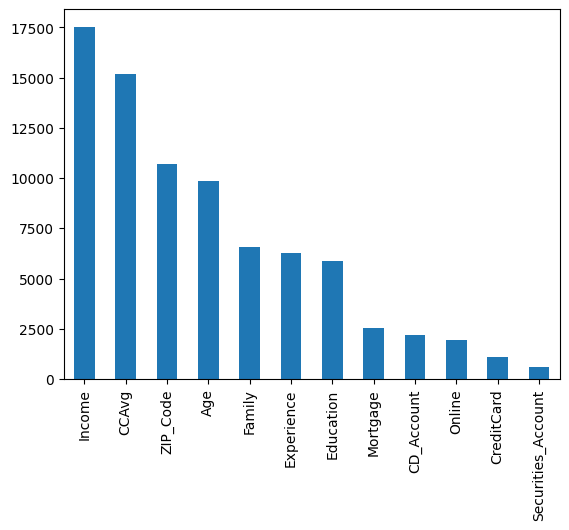

In [ ]:
# 변수 중요도 시각화
val_imp['imp'].sort_values(axis=0, ascending=False).plot(kind='bar')
plt.show()

# 모델의 저장과 불러오기

In [ ]:
import pickle

In [ ]:
# 저장 객체 정의
save_object = [model, params, x_valid_include_pred, le_zip, le_edu, le_sec, le_cd, le_online, le_credit]

In [ ]:
# 저장
with open(file='my_model.pickle', mode='wb') as f:
    pickle.dump(save_object, f)

In [ ]:
# 저장된 객체 불러오기
with open(file='my_model.pickle', mode='rb') as f:
    load_object = pickle.load(f)

In [ ]:
# 저장된 객체 분리
model = load_object[0]
params = load_object[1]
valid_data = load_object[2]
le_zip = load_object[3]
le_edu = load_object[4]
le_sec = load_object[5]
le_cd = load_object[6]
le_online = load_object[7]
le_credit = load_object[8]

In [ ]:
# 예측
valid_data['pred'] = model.predict_proba(x_valid)[:, 1]
valid_data


In [ ]:
# 검증
score = roc_auc_score(valid_data['Personal Loan'], valid_data['pred'])

print('ROC AUC Score = ', score)

ROC AUC Score =  0.9989859882005899
